## 1. Choix de la décennie 1840-1849

In [4]:
ANNEE = '1840'

## 2. Clustering

### importations et téléchargements

In [2]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Definition du chemin vers les fichiers textes

In [5]:
data_path = "../data/txt/"

### Charger tous les  fichiers de la décennie et en créer une liste de textes

In [6]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{ANNEE[:-1]}" in f]

### Charger les textes des fichiers de la décennie

In [7]:
texts = [open(data_path + f).read() for f in files]

### Définition de la fonction de prétraitement

In [8]:
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Les traitements

In [20]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [21]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 17.6 s, sys: 0 ns, total: 17.6 s
Wall time: 17.6 s


In [22]:
N_CLUSTERS = 3

In [23]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [24]:
clusters = km_model.fit_predict(tfidf_vectors)

In [25]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [26]:
pprint(dict(clustering))

{0: ['Bxl_1849_Tome_I1_Part_2.txt',
     'Bxl_1849_Tome_I1_Part_5.txt',
     'Bxl_1849_Tome_II1_Part_1.txt',
     'Bxl_1849_Tome_II1_Part_5.txt',
     'Bxl_1849_Tome_II1_Part_6.txt',
     'Bxl_1849_Tome_II1_Part_7.txt'],
 1: ['Bxl_1847_Tome_I1_Part_2.txt',
     'Bxl_1847_Tome_I1_Part_3.txt',
     'Bxl_1847_Tome_I1_Part_4.txt',
     'Bxl_1847_Tome_I1_Part_5.txt',
     'Bxl_1848_Tome_I1_Part_1.txt',
     'Bxl_1848_Tome_I1_Part_2.txt',
     'Bxl_1848_Tome_I1_Part_3.txt'],
 2: ['Bxl_1849_Tome_I1_Part_1.txt',
     'Bxl_1849_Tome_I1_Part_3.txt',
     'Bxl_1849_Tome_I1_Part_4.txt',
     'Bxl_1849_Tome_II1_Part_2.txt',
     'Bxl_1849_Tome_II1_Part_3.txt',
     'Bxl_1849_Tome_II1_Part_4.txt']}


In [27]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

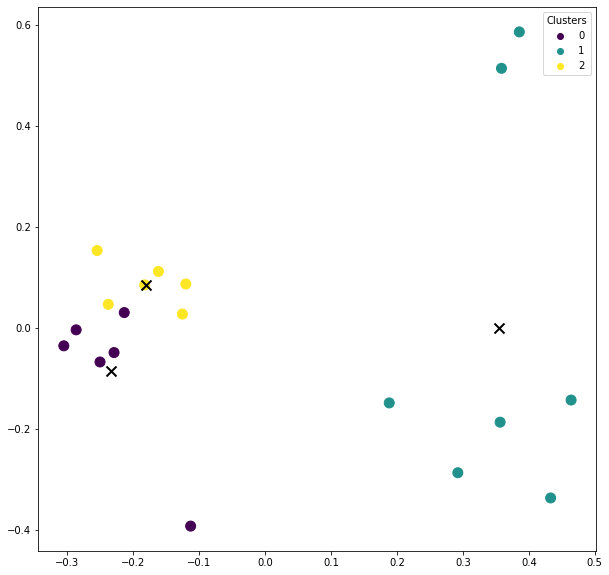

In [28]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## 5. Entraitenement du modèle

### importations

In [29]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

### Chargement et traitement des phrases du corpus

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [30]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [31]:
infile = f"../data/sent.txt"
sentences = MySentences(infile)

sentences = [sentence for sentence in sentences]

### Détection des bigrams

In [32]:
bigram_phrases = Phrases(sentences)

### Conversion des `Phrases` en objet `Phraser`

In [33]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [34]:
trigram_phrases = Phrases(bigram_phraser[sentences])

### Conversion des `Phrases` en objet `Phraser`

In [35]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [36]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

### Entrainement d'un modèle Word2Vec sur ce corpus

In [37]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 1min 11s, sys: 2.7 s, total: 1min 14s
Wall time: 32.8 s


In [39]:
outfile = f"../data/bulletins.model"
model.save(outfile)

In [40]:
model = Word2Vec.load("../data/bulletins.model")

In [41]:
model.wv["blanchisserie"]

array([ 0.12951575, -0.52853256,  0.40600666, -0.17441586,  0.12594558,
       -1.0690298 ,  0.3599124 ,  0.19440144, -0.5822103 ,  0.03346932,
        0.19939691, -0.7782032 , -0.27837867,  0.64731246,  0.15356648,
       -0.29590577,  0.02024636,  0.5308609 ,  0.16669884,  0.86198455,
        0.6862544 ,  0.46660718,  0.1932657 ,  0.53665537,  0.10128158,
       -0.07400858, -0.57398313,  0.04478179,  0.14165738,  0.09049387,
       -0.6238903 ,  0.09004402], dtype=float32)

### Calculer la similarité entre deux termes

In [42]:
model.wv.similarity("architecte", "boulanger")

0.41742617

### Chercher les mots les plus proches d'un terme donné

In [43]:
model.wv.most_similar("architecte", topn=10)

[('honorable_membre', 0.9097857475280762),
 ('honorable_conseiller', 0.8380672931671143),
 ('exemple', 0.8364467620849609),
 ('entrepreneur', 0.8100908398628235),
 ('avantage', 0.7904627919197083),
 ('essai', 0.7902554273605347),
 ('auteur', 0.7872560024261475),
 ('ajournement', 0.7793064117431641),
 ('engagement', 0.7757325172424316),
 ('experience', 0.7748648524284363)]

### Faire des recherches complexes à travers l'espace vectoriel

In [44]:
print(model.wv.most_similar(positive=['administration', 'philanthropie'], negative=['belgique']))

[('envoyer', 0.7572186589241028), ('approbation', 0.7475339770317078), ('aux_fins', 0.7473394870758057), ('autorite_superieure', 0.7447587251663208), ('nistration', 0.7378610968589783), ('conseil_general', 0.7343752980232239), ('secours_demande', 0.7311606407165527), ('attraire_en_justice', 0.7037755846977234), ("'_autorite_competente", 0.6863450407981873), ('accepter', 0.6681413650512695)]


## 6. Exploration du modèle

In [45]:
model.wv.similarity("construire", "administration")

0.14125814

In [46]:
model.wv.similarity("gendarmerie", "caserne")

0.61988354

In [47]:
model.wv.similarity("bruxellois", "waterloo")

0.5031336

In [48]:
model.wv.most_similar("bruxellois", topn=10)

[('associes', 0.9202000498771667),
 ('souvenirs', 0.9061274528503418),
 ('habitues', 0.8997080326080322),
 ('quelques_personnes', 0.8926219344139099),
 ('fautes', 0.8900251984596252),
 ('deux_theatres', 0.8892890214920044),
 ('epreuves', 0.889273464679718),
 ('sifflets', 0.8888795971870422),
 ('approvisionnements', 0.888349175453186),
 ('deux_administrations', 0.8880735635757446)]

In [49]:
model.wv.most_similar("gendarmerie", topn=10)

[('carrosserie', 0.9223438501358032),
 ('pneumonie', 0.9089800715446472),
 ('serrurerie', 0.9072736501693726),
 ('couronne', 0.9030741453170776),
 ('chaire', 0.8925639390945435),
 ('batterie', 0.8920012712478638),
 ('militaire', 0.8916779160499573),
 ('betterave', 0.8916401863098145),
 ('finisterrae', 0.890042781829834),
 ('hubert', 0.8897148370742798)]

In [50]:
model.wv.most_similar("administration", topn=10)

[('autorite_superieure', 0.8538719415664673),
 ('autorite_communale', 0.8065093755722046),
 ('nistration', 0.7890928387641907),
 ("'_administration_communale", 0.7791832685470581),
 ('autorisation', 0.7701063752174377),
 ('inspection', 0.7585645914077759),
 ('entrepreneur', 0.7447304725646973),
 ('autorite', 0.7407077550888062),
 ('conseil_general', 0.7328884601593018),
 ('ministration', 0.7302660346031189)]